## Import Packages and Data

In [2]:
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
hostname = input("Enter server hostname: ")
username = input("Enter username: ")
password = getpass("Enter password: ")
database_name = input("Enter database name: ")

Enter server hostname: spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com
Enter username: introml568
Enter password: ········
Enter database name: synthea-omop


In [8]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [10]:
# Read in SQL tables through Pandas
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);
omop_condition = pd.read_sql("select * from omop.condition_occurrence", db_connection);
omop_concept = pd.read_sql("select * from omop.concept", db_connection);
omop_meas = pd.read_sql("select * from omop.measurement", db_connection);

In [15]:
# merge tables
df_per=pd.merge(omop_person,omop_visit,on='person_id',how='inner')
df_con=pd.merge(omop_condition,omop_concept,left_on='condition_concept_id',right_on='concept_id',how='left')
df_meas=pd.merge(omop_meas[['visit_occurrence_id','measurement_concept_id','value_source_value']], 
                 omop_concept[['concept_id', 'concept_name']], left_on='measurement_concept_id', right_on='concept_id')

In [16]:
# pivot measurements table from long to wide
df_meas=df_meas[['visit_occurrence_id','concept_name', 'value_source_value']]
df_meas_wide=pd.pivot_table(df_meas,index='visit_occurrence_id',columns='concept_name',values='value_source_value',aggfunc='first')

## Create Dataframe

In [17]:
# create dataframe
col_keep = ['visit_occurrence_id','visit_start_date','person_id', 'gender_concept_id','race_source_value', 'ethnicity_source_value','birth_datetime',
           'visit_start_datetime','visit_end_datetime']
df = df_per[col_keep]
df['age_at_visit']=df.apply(lambda x:relativedelta(x['visit_start_datetime'],x['birth_datetime']).years,axis=1)
df['visit_length']=df.apply(lambda x: relativedelta(x['visit_end_datetime'], x['visit_start_datetime']).hours, axis=1)

In [18]:
# add columns of conditions
person_hyp = df_con[df_con['concept_name'].str.lower().str.contains('hypertension')]['visit_occurrence_id']
person_db = df_con[df_con['concept_name'].str.lower().str.contains('diabetes')]['visit_occurrence_id']
df['condition_hypertension']=df.visit_occurrence_id.apply(lambda x:1 if x in person_hyp else 0)
df['condition_diabetes']=df.visit_occurrence_id.apply(lambda x:1 if x in person_db else 0)

In [19]:
# add columns of measurements
df=pd.merge(df,df_meas_wide,on='visit_occurrence_id',how='left')

In [20]:
# inclusion criteria
# living
omop_death = pd.read_sql("select * from omop.death", db_connection);
person_death = omop_death['person_id']
df = df[~df['person_id'].isin(person_death)]

# age 52-56
df = df[(df['age_at_visit']>=52) & (df['age_at_visit']<=56)]

# visits 1-37
num_visit = df.groupby(['person_id'])['visit_start_date'].agg('count').reset_index()
num_visit_in = num_visit[(num_visit['visit_start_date']>=1) & (num_visit['visit_start_date']<=37)]
df = df[df['person_id'].isin(num_visit_in['person_id'])]

In [21]:
# exclusion criteria
# 3-17 visits with high systolic blood pressure
num_visit_ex = df[df['Systolic blood pressure'].astype(float)>140].groupby(['person_id'])['visit_start_date'].agg('count').reset_index()
person_ex = num_visit_ex[(num_visit_ex['visit_start_date']>=3) & (num_visit_ex['visit_start_date']<=17)]['person_id']
df = df[~df['person_id'].isin(person_ex)]

# do not contain any associated measurements
visit_na = df[df.iloc[:,13:186].isnull().all(axis=1)]['visit_occurrence_id']
df = df[~df['visit_occurrence_id'].isin(visit_na)]

In [22]:
# drop unwanted columns 
df = df.drop(['birth_datetime','visit_start_datetime', 'visit_end_datetime'],axis='columns')

In [23]:
# write to csv file
df.to_csv("/Users/helen/Desktop/BIS568/hw1_Qin/dat.csv")

## Visualizing Descriptive Statistics

In [24]:
# add 'gender_source_value' column to the dataset
df1 = pd.merge(df, df_per[['visit_occurrence_id','gender_source_value']], on='visit_occurrence_id', how='left')
# convert age_at_visit from float to int
df1['age_at_visit'] = df1['age_at_visit'].astype(int)

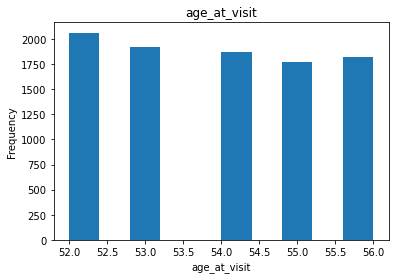

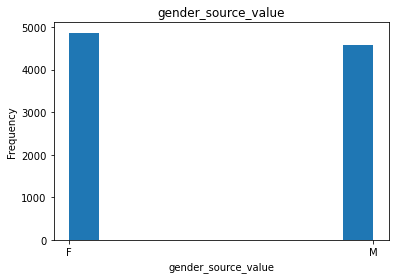

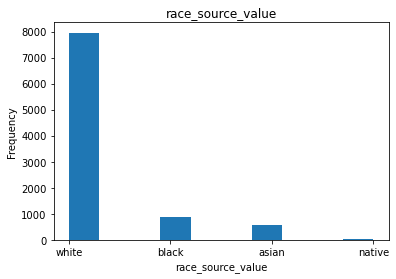

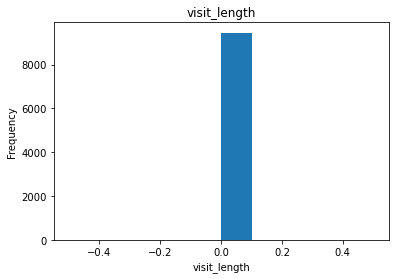

In [25]:
# histograms
cat_col = ['age_at_visit','gender_source_value', 'race_source_value', 'visit_length']
for cat in cat_col:
    plt.hist(x=df1[cat])
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.title(cat)
    plt.show()

Patients' age and gender are nearly evenly distributed in our cohort, while the distribution of race varies considerably. White people visit hospitals far more often than other races. All patients' visits end in one day.

*A small problem here: I set the format of visit_at_age to int to avoid having results like "52.0" in the plot. But it didn't work and the x-axis in the plot still shows the ages in float type.*

In [26]:
# number of visit number
df1['visit_number'] = df1.groupby(df1['person_id'])['visit_start_date'].rank(method='dense').astype(int)

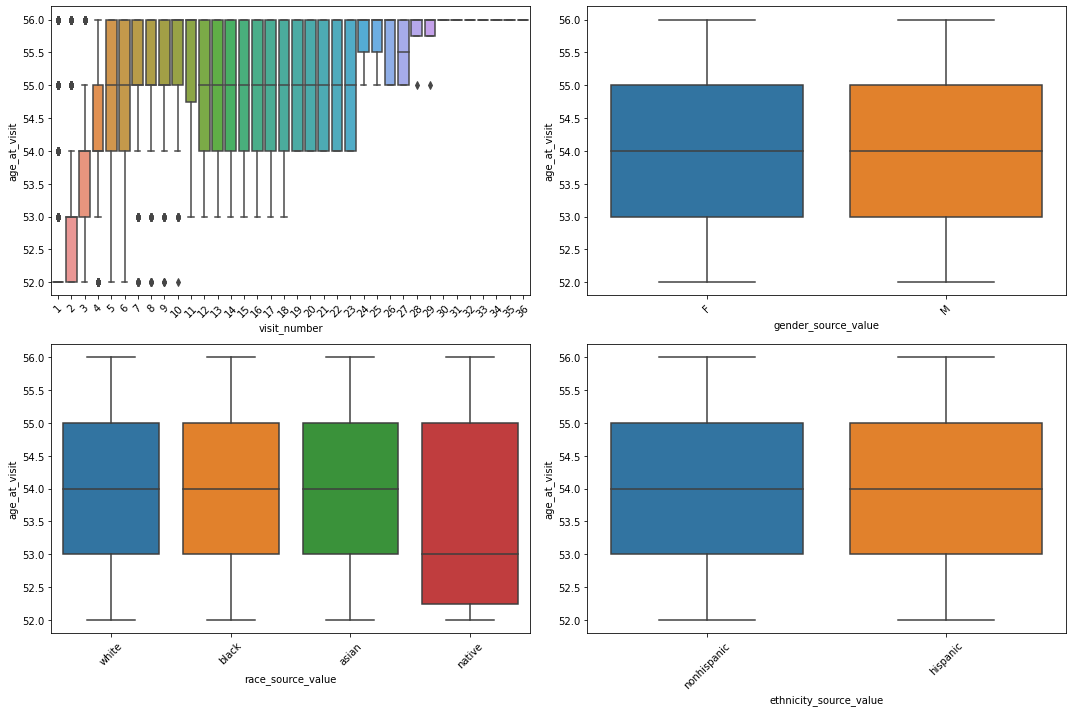

In [27]:
# box plots
box_col = ['visit_number','gender_source_value','race_source_value','ethnicity_source_value','age_at_visit']
df_box = df1[box_col]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(fig.axes):
    if i < len(df_box.columns)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(data=df_box,x=df_box.columns[i], y='age_at_visit',ax=ax)
fig.tight_layout()

We don't have information about where the patient is admitted and where the patient is discharged in our dataset, so here we only show the box plots for patients age at visit by number of visits number, gender, race and ethnicity. From the plots, we can observe that patients at early visits are often relatively younger; the distributions of patients' age at visit are similar between female and male, nonhispanic and hispanic; native patients are younger than patients of other races.

## Short Answer Questions

Tables:
* concept: Concept table contains information of concepts, including concept id, concept name and etc. It relates to tables including condition_occurance, measurement, observation, etc. by its primary key "concept_id", which is foreign key to these other tables. These other tables all have a column of person_id so concept table is related to person_id.
* person: Person table contains patients information, including gender, race, ethnicity, etc. Person id is the primay key of person table.
* measurement: Measurement table contains information of patients' measurement in each visit. Person id is the foreign key of measurement table.

Research Question:
* Question: Predict whether the patients will have a next visit.
* Solution: Build random forest model to predict whether the patients will have a next visit based on their measurements from last visit and demographic features. Because our dataset has a lot of measurements, including all the measurements as features may have a risk of overfitting. Random forest are less prone to overfitting and can derive the importance of the features on prediction, which is also useful for feature selection.